# US Carbon Dioxide (CO₂) emmisions analysis : A Sectoral and Regional Perspective to Inform ESG Reporting and Climate Policy

This analysis is an **Exploratory Data Analysis (EDA)** project aimed at uncovering trends and patterns in U.S. CO₂ emissions data across time, regions, sectors, and fuel types. The primary goal is to support:

- ESG and sustainability reporting,
- Climate strategy development,
- Policy-relevant insight generation.

The objectives of this project were to:
- Assess temporal trends in CO₂ emssions.
- Uncovering and comparing trends in sectors and fuels.
- Discover which state emits the most CO₂ and to see what drives those emissions.
- Evaluate total vs average emissions.

As such, the focus is on **descriptive summaries**, **visual pattern recognition**, and **interactive exploration**, rather than formal hypothesis testing or inferential statistics. Statistical tests (e.g., t-tests, ANOVA) are typically reserved for situations where we are testing causal relationships or comparing controlled groups, which is not the objective here.

The insights drawn from totals, averages, and their temporal-spatial variation are sufficient to guide strategic sustainability decisions and communicate key findings effectively.


In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Importing data set from kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdelrahman16/co2-emissions-usa")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/co2-emissions-usa


In [3]:
# List files in the downloaded directory to find the CSV file name
import os
print("Files in the downloaded directory:")
for file in os.listdir(path):
    print(file)


Files in the downloaded directory:
emissions.csv


In [4]:
# Load Dataset
# Assuming the CSV file is named 'co2-emissions-usa.csv' based on the dataset name.
# If the file name is different, replace 'co-_emissions-usa.csv' with the actual name.
# Find the actual CSV file name in the downloaded directory
csv_file_name = None
for file in os.listdir(path):
    if file.endswith('.csv'):
        csv_file_name = file
        break

if csv_file_name:
    csv_file_path = os.path.join(path, csv_file_name) # Construct the full path to the CSV file
    df = pd.read_csv(csv_file_path)
    df.head()
else:
    print("No CSV file found in the downloaded directory.")

### Inspecting and cleaning the data

In [5]:
# Building a wrangle function to clean the data
import pandas as pd

def wrangle_co2_emissions(df):
    """
    Cleans the CO₂ emissions dataset by removing aggregate rows:
    - Removes 'United States' rows
    - Removes 'All Fuels' rows
    - Removes 'Total carbon dioxide emissions from all sectors' rows
    """
    df1 = df.copy()

    # Drop rows where the state is "United States"
    df1 = df1[df1["state-name"] != "United States"]

    # Drop rows where fuel is "All Fuels"
    df1 = df1[df1["fuel-name"] != "All Fuels"]

    # Drop rows where sector is "Total carbon dioxide emissions from all sectors"
    df1 = df1[
        df1["sector-name"] != "Total carbon dioxide emissions from all sectors"
    ]

    # Rename 'value' column to 'CO2 Emissions (tCO2e)'
    df1.rename(columns={"value": "CO2 Emissions (tCO2e)"}, inplace=True)

    # Remove 'carbon dioxide emissions' from the 'sector-name' column
    df1['sector-name'] = df1['sector-name'].str.replace(' carbon dioxide emissions', '', regex=False).str.strip()


    # Optional: Reset index
    df1.reset_index(drop=True, inplace=True)

    return df1



The following code was used to perform an initial inspection of the raw dataset to identify potential issues such as missing values, inconsistent formats, or duplicates. After applying the wrangle() function to preprocess and clean the data, a second inspection was conducted to validate the integrity and readiness of the dataset for analysis.

In [6]:
df1 = wrangle_co2_emissions(df)
df1.head()

,year,state-name,sector-name,fuel-name,CO2 Emissions (tCO2e)
0,1970,Alabama,Industrial,Coal,26.721507
1,1970,Alabama,Industrial,Petroleum,3.577779
2,1970,Alabama,Industrial,Natural Gas,8.944097
3,1970,Alabama,Residential,Coal,0.163635
4,1970,Alabama,Residential,Petroleum,1.123947


In [7]:
df1.shape

(34916, 5)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34916 entries, 0 to 34915
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   34916 non-null  int64  
 1   state-name             34916 non-null  object 
 2   sector-name            34916 non-null  object 
 3   fuel-name              34916 non-null  object 
 4   CO2 Emissions (tCO2e)  34916 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [9]:
df1.isnull().sum()

,0
year,0
state-name,0
sector-name,0
fuel-name,0
CO2 Emissions (tCO2e),0


In [10]:
df1["state-name"].nunique()

51

In [11]:
df1['sector-name'].value_counts()

,count
sector-name,
Industrial,7652
Electric Power,7448
Commercial,7320
Residential,6996
Transportation,5500


In [12]:
df1['fuel-name'].value_counts()

,count
fuel-name,
Petroleum,13238
Natural Gas,12893
Coal,8785


# Exploratory Data Analysis

Assesing temporal trends in CO2 emissions

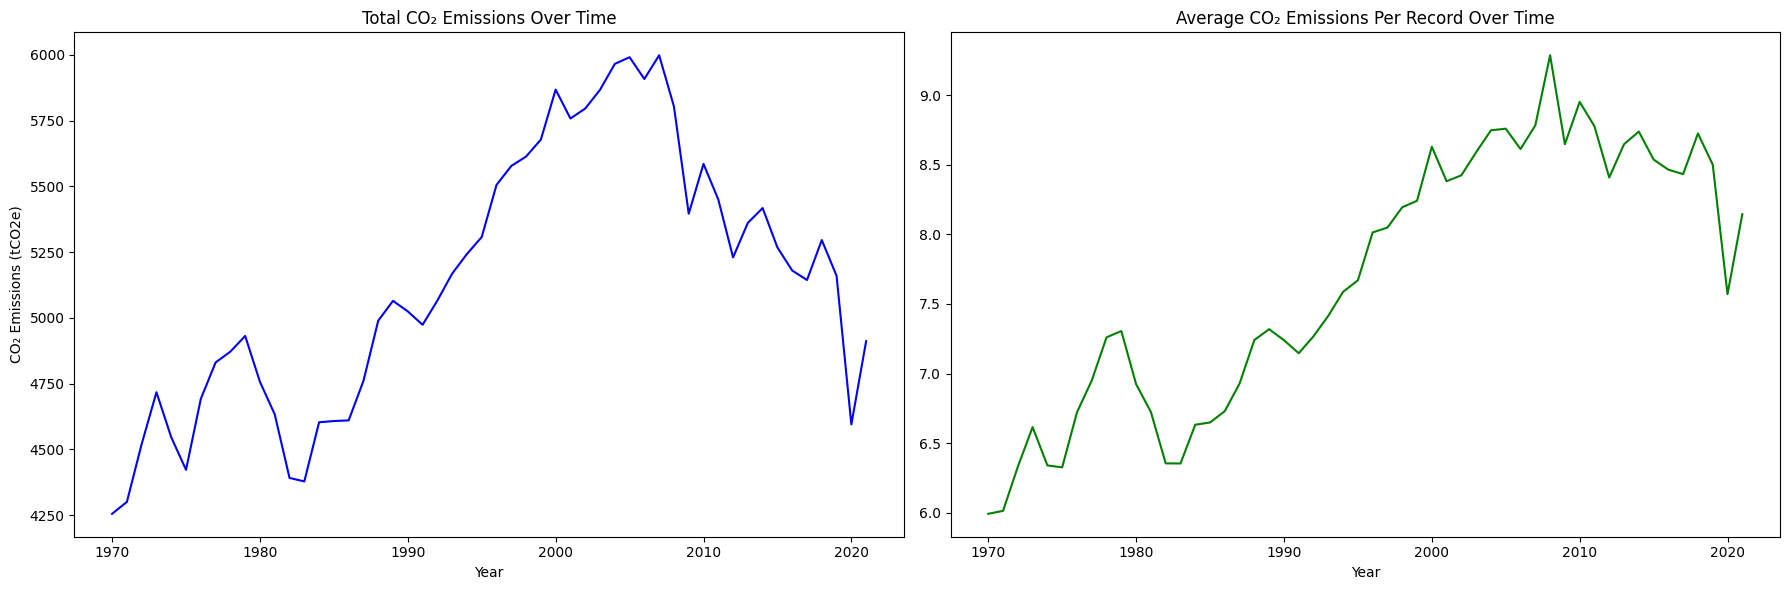

In [13]:
# Group data
emissions_by_year_sum = df1.groupby("year")["CO2 Emissions (tCO2e)"].sum()
emissions_by_year_avg = df1.groupby("year")["CO2 Emissions (tCO2e)"].mean()

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot total emissions
axes[0].plot(emissions_by_year_sum.index, emissions_by_year_sum.values, color='blue')
axes[0].set_title("Total CO₂ Emissions Over Time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("CO₂ Emissions (tCO2e)")

# Plot average emissions
axes[1].plot(emissions_by_year_avg.index, emissions_by_year_avg.values, color='green')
axes[1].set_title("Average CO₂ Emissions Per Record Over Time")
axes[1].set_xlabel("Year")


# Improve layout
plt.tight_layout()
plt.show()


CO2 emissions peaked towrads the the 2010s and dropped towards 2020. The drop in emmisioons in 2020 would likely be due to the COVID-19 pandemic but began to rise afterwards

Sector and fuel pivot matrix

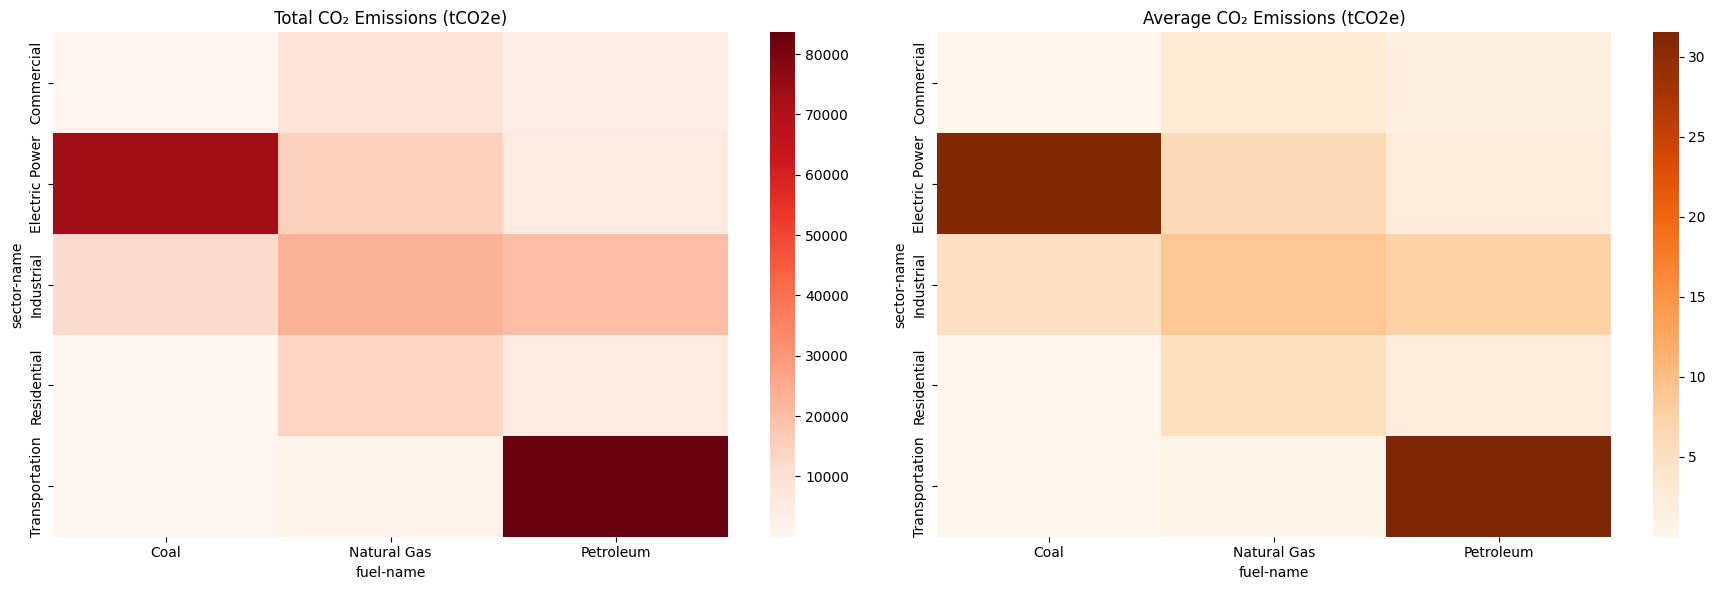

In [14]:
# Create the two pivot tables
pivot_sum = df1.pivot_table(
    values="CO2 Emissions (tCO2e)",
    index="sector-name",
    columns="fuel-name",
    aggfunc="sum"
)

pivot_mean = df1.pivot_table(
    values="CO2 Emissions (tCO2e)",
    index="sector-name",
    columns="fuel-name",
    aggfunc="mean"
)

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap for total emissions
sns.heatmap(pivot_sum, cmap="Reds", ax=axes[0],  fmt=".1f")
axes[0].set_title("Total CO₂ Emissions (tCO2e)")

# Heatmap for average emissions
sns.heatmap(pivot_mean, cmap="Oranges", ax=axes[1], fmt=".1f")
axes[1].set_title("Average CO₂ Emissions (tCO2e)")

# Improve layout
plt.tight_layout()
plt.show()


The pivot chart reveals a correlation emissions between transportation and petroleum and elcectrical power and coal. This suggests that Transportation is heavily reliant on petrolium and electrical power is heavily reliant on coal for its operations.

Comparing average carobon emmisions across all states

In [15]:
# Group by state and calculate mean CO₂ emissions
avg_emissions_by_state = df1.groupby("state-name")["CO2 Emissions (tCO2e)"].mean().reset_index()

# Rename column for clarity
avg_emissions_by_state.rename(columns={"CO2 Emissions (tCO2e)": "Average CO2 Emissions (tCO2e)"}, inplace=True)

# Sort descending for easy viewing
avg_emissions_by_state = avg_emissions_by_state.sort_values(by="Average CO2 Emissions (tCO2e)", ascending=False).reset_index(drop=True)

# Display result
print(avg_emissions_by_state.head(10))


     state-name  Average CO2 Emissions (tCO2e)
0         Texas                      43.015387
1    California                      27.029344
2  Pennsylvania                      19.173258
3          Ohio                      18.290951
4     Louisiana                      16.054856
5      Illinois                      16.001100
6       Florida                      15.207171
7      New York                      15.001111
8       Indiana                      14.321190
9      Michigan                      12.849705


In [16]:
# Dictionary to map full names to abbreviations
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC'
}

# Apply the mapping
avg_emissions_by_state["state_code"] = avg_emissions_by_state["state-name"].map(us_state_abbrev)


In [17]:
# --- AVERAGE EMISSIONS MAP ---
fig_avg = px.choropleth(
    avg_emissions_by_state,
    locations="state_code",
    locationmode="USA-states",
    color="Average CO2 Emissions (tCO2e)",
    color_continuous_scale="YlGnBu",
    scope="usa",
    title="Average CO₂ Emissions by U.S. State (1970–2021)",
    labels={"Average CO2 Emissions (tCO2e)": "Avg CO₂ (tCO2e)"}
)
fig_avg.show()

# --- TOTAL EMISSIONS MAP ---
# Group and rename
total_emissions_by_state = df1.groupby("state-name")["CO2 Emissions (tCO2e)"].sum().reset_index()
total_emissions_by_state.rename(columns={"CO2 Emissions (tCO2e)": "Total CO2 Emissions (tCO2e)"}, inplace=True)
total_emissions_by_state["state_code"] = total_emissions_by_state["state-name"].map(us_state_abbrev)

fig_total = px.choropleth(
    total_emissions_by_state,
    locations="state_code",
    locationmode="USA-states",
    color="Total CO2 Emissions (tCO2e)",
    color_continuous_scale="YlGnBu",
    scope="usa",
    title="Total CO₂ Emissions by U.S. State (1970–2021)",
    labels={"Total CO2 Emissions (tCO2e)": "Total CO₂ (tCO2e)"}
)
fig_total.show()


Texas had the highest total and average emissions out of all the states in the USA.

In [18]:
# Step 3: Sort by emissions descending
# Corrected the column name to "Average CO2 Emissions (tCO2e)"
# The previous cell overwrote avg_emissions_by_state, and the column name is back to the original.
# We need to sort by the column that actually exists in the current avg_emissions_by_state DataFrame.
# Based on the global variables, the column is currently named 'CO2 Emissions (tCO2e)'.
# Let's re-calculate and rename it here to avoid reliance on the exact state of previous cells,
# which is better practice for self-contained code blocks.

# Recalculate average emissions by state just before sorting to ensure correct column name
avg_emissions_by_state = df1.groupby("state-name")["CO2 Emissions (tCO2e)"].mean().reset_index()

# Rename column for clarity
avg_emissions_by_state.rename(columns={"CO2 Emissions (tCO2e)": "Average CO2 Emissions (tCO2e)"}, inplace=True)


top_states = avg_emissions_by_state.sort_values(by="Average CO2 Emissions (tCO2e)", ascending=False)

# Remove the "United States" row from the result
# Note: The wrangle function already removed "United States", but this is good practice
top_states_cleaned = top_states[top_states["state-name"] != "United States"]

# Get the top 5 states only
# Changed head(10) to head(5) based on the print statement description "Top 5 States..."
top_5_states = top_states_cleaned.head().reset_index(drop=True)

# Display as a clean DataFrame
print("Top 5 States with Highest Average CO₂ Emissions:")
print(top_5_states)

Top 5 States with Highest Average CO₂ Emissions:
     state-name  Average CO2 Emissions (tCO2e)
0         Texas                      43.015387
1    California                      27.029344
2  Pennsylvania                      19.173258
3          Ohio                      18.290951
4     Louisiana                      16.054856


Top 5 totals

In [19]:
# Calculate the total emissions per state
total_emissions_by_state = df1.groupby("state-name")["CO2 Emissions (tCO2e)"].sum().reset_index()

# Rename the column for clarity
total_emissions_by_state.rename(columns={"CO2 Emissions (tCO2e)": "Total CO2 Emissions (tCO2e)"}, inplace=True)

# Sort by total emissions descending
top_states = total_emissions_by_state.sort_values(by="Total CO2 Emissions (tCO2e)", ascending=False)

# Remove the "United States" row from the result (already done by wrangle function, but good practice)
top_states_cleaned = top_states[top_states["state-name"] != "United States"]

# Get the top 5 states with the highest total emissions
top_5_states = top_states_cleaned.head().reset_index(drop=True)

# Display as a clean DataFrame
print("Top 5 States with Highest Total CO₂ Emissions:")
print(top_5_states)

Top 5 States with Highest Total CO₂ Emissions:
     state-name  Total CO2 Emissions (tCO2e)
0         Texas                 29852.678554
1    California                 18055.601943
2  Pennsylvania                 13843.092163
3          Ohio                 13132.902469
4      Illinois                 11552.794306


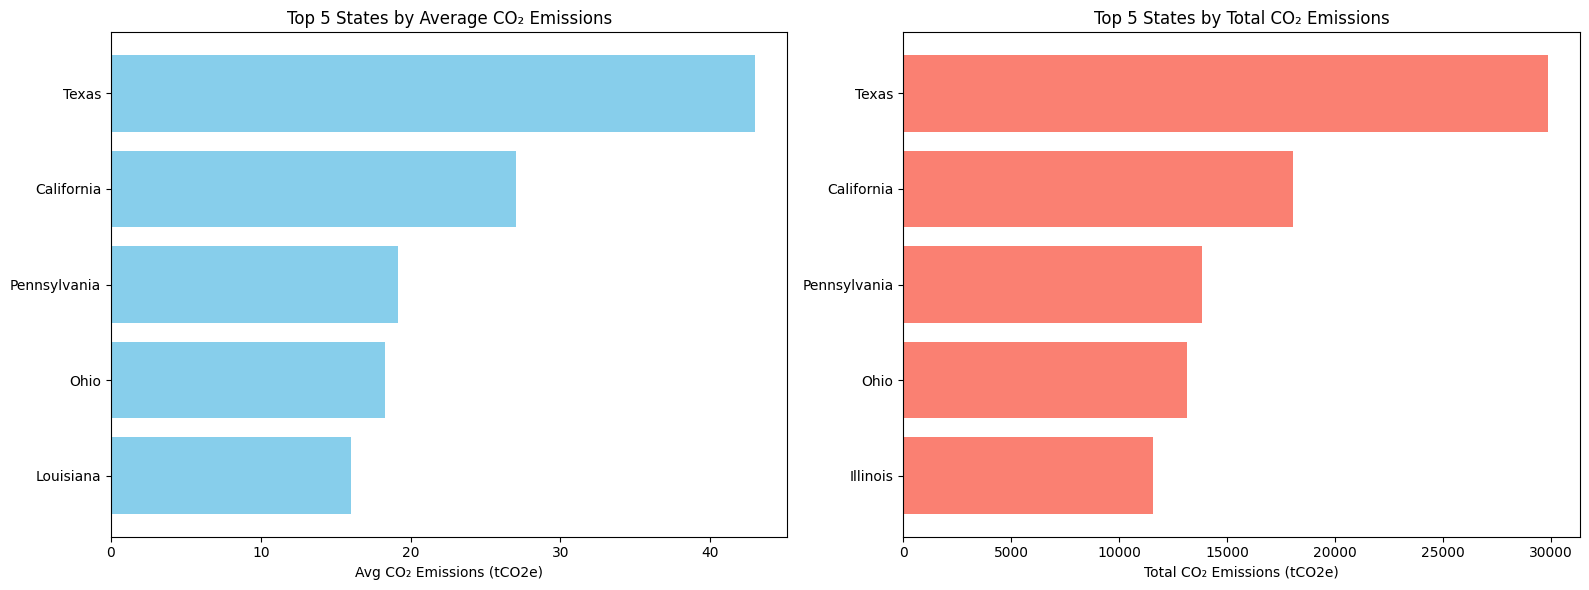

In [20]:
# Step 1: Average emissions per state
avg_emissions_by_state = df1.groupby("state-name")["CO2 Emissions (tCO2e)"].mean().reset_index()
top_5_avg = avg_emissions_by_state.sort_values(by="CO2 Emissions (tCO2e)", ascending=False).head()

# Step 2: Total emissions per state
total_emissions_by_state = df1.groupby("state-name")["CO2 Emissions (tCO2e)"].sum().reset_index()
top_5_total = total_emissions_by_state.sort_values(by="CO2 Emissions (tCO2e)", ascending=False).head()

# Step 3: Create side-by-side horizontal bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# --- Average Emissions Chart ---
axes[0].barh(top_5_avg["state-name"], top_5_avg["CO2 Emissions (tCO2e)"], color="skyblue")
axes[0].set_title("Top 5 States by Average CO₂ Emissions")
axes[0].set_xlabel("Avg CO₂ Emissions (tCO2e)")
axes[0].invert_yaxis()  # Highest at the top

# --- Total Emissions Chart ---
axes[1].barh(top_5_total["state-name"], top_5_total["CO2 Emissions (tCO2e)"], color="salmon")
axes[1].set_title("Top 5 States by Total CO₂ Emissions")
axes[1].set_xlabel("Total CO₂ Emissions (tCO2e)")
axes[1].invert_yaxis()

# --- Layout ---
plt.tight_layout()
plt.show()


Displaying Trends in Total Emissions across the 50 years

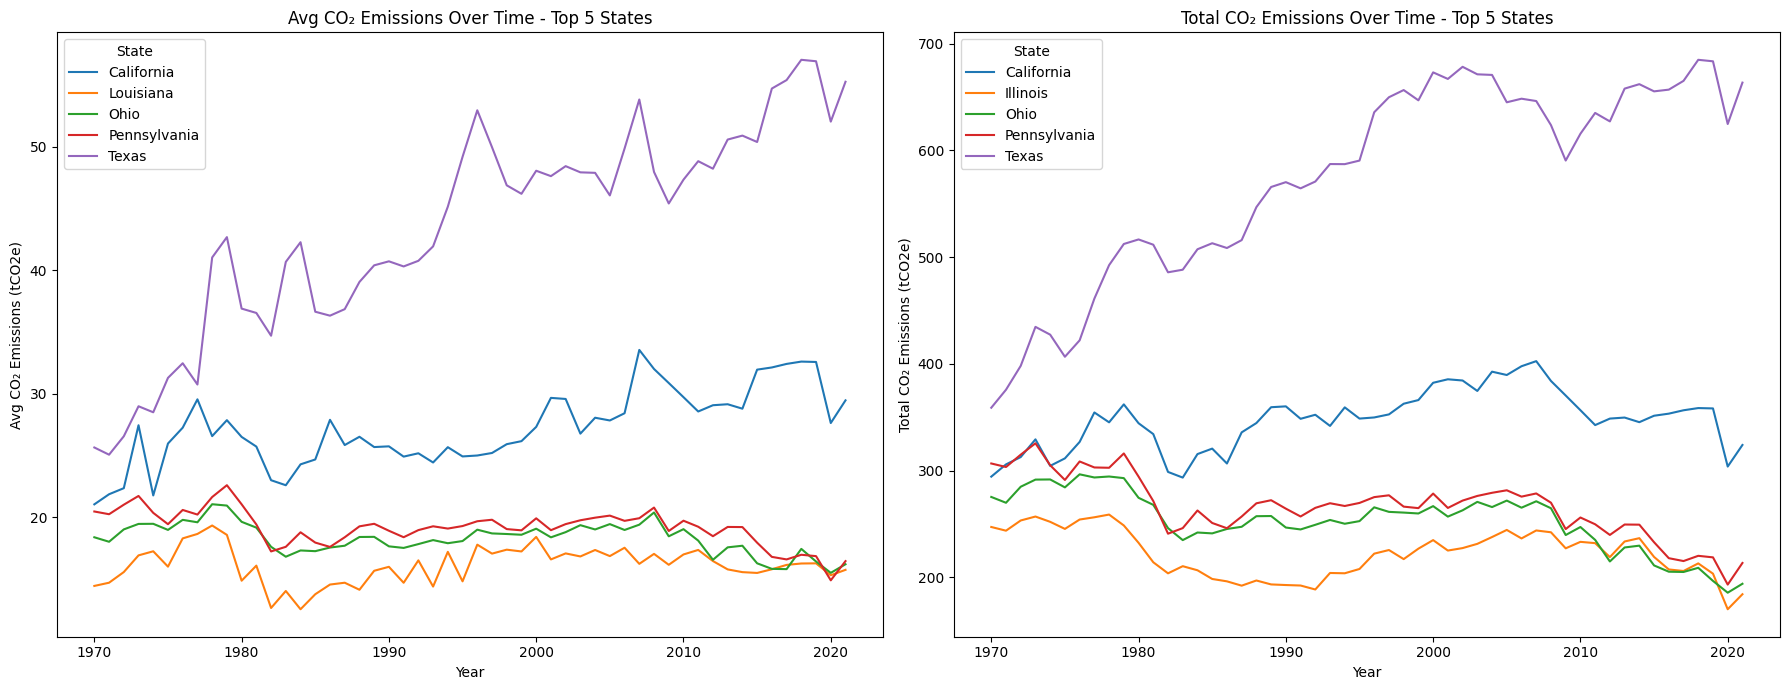

In [21]:
# --- AVERAGE EMISSIONS ANALYSIS ---
# Step 1: Top 5 by average
top_states_avg = df1.groupby('state-name')['CO2 Emissions (tCO2e)'].mean().sort_values(ascending=False).head().index

# Step 2: Filter
top_states_data_avg = df1[df1['state-name'].isin(top_states_avg)]

# Step 3: Group by year and state
avg_emissions_by_state = top_states_data_avg.groupby(['year', 'state-name'])['CO2 Emissions (tCO2e)'].mean().reset_index()

# --- TOTAL EMISSIONS ANALYSIS ---
# Step 1: Top 5 by total
top_states_total = df1.groupby('state-name')['CO2 Emissions (tCO2e)'].sum().sort_values(ascending=False).head().index

# Step 2: Filter
top_states_data_total = df1[df1['state-name'].isin(top_states_total)]

# Step 3: Group by year and state
total_emissions_by_state = top_states_data_total.groupby(['year', 'state-name'])['CO2 Emissions (tCO2e)'].sum().reset_index()

# --- PLOTTING SIDE BY SIDE ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

# Left: Average emissions plot
for state in avg_emissions_by_state['state-name'].unique():
    state_data = avg_emissions_by_state[avg_emissions_by_state['state-name'] == state]
    axes[0].plot(state_data['year'], state_data['CO2 Emissions (tCO2e)'], label=state)

axes[0].set_title('Avg CO₂ Emissions Over Time - Top 5 States')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Avg CO₂ Emissions (tCO2e)')
axes[0].legend(title='State')

# Right: Total emissions plot
for state in total_emissions_by_state['state-name'].unique():
    state_data = total_emissions_by_state[total_emissions_by_state['state-name'] == state]
    axes[1].plot(state_data['year'], state_data['CO2 Emissions (tCO2e)'], label=state)

axes[1].set_title('Total CO₂ Emissions Over Time - Top 5 States')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total CO₂ Emissions (tCO2e)')
axes[1].legend(title='State')

plt.tight_layout()
plt.show()


# Displaying average and total CO2 emissions by across all states for both fuel type and sector

Emissions by fuel type

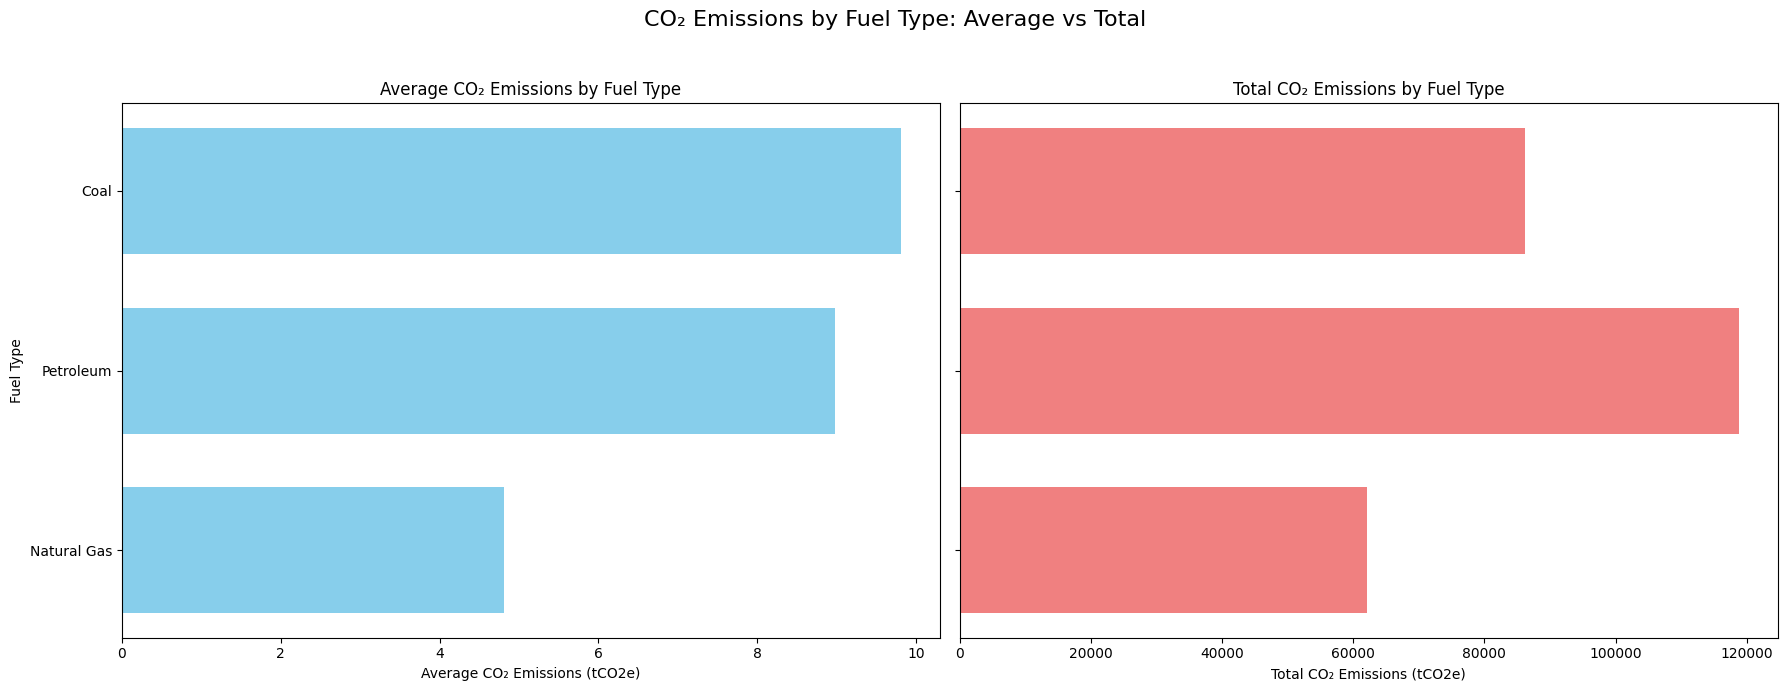

In [22]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)  # Side by side

# --- Average Emissions by Fuel Type ---
emissions_by_fuel_avg = df1.groupby("fuel-name")["CO2 Emissions (tCO2e)"].mean().reset_index()
emissions_by_fuel_avg = emissions_by_fuel_avg.sort_values(by="CO2 Emissions (tCO2e)", ascending=True)

ax1.barh(
    y=emissions_by_fuel_avg["fuel-name"],
    width=emissions_by_fuel_avg["CO2 Emissions (tCO2e)"],
    color="skyblue",
    height=0.7
)
ax1.set_xlabel('Average CO₂ Emissions (tCO2e)')
ax1.set_ylabel('Fuel Type')
ax1.set_title('Average CO₂ Emissions by Fuel Type')

# --- Total Emissions by Fuel Type ---
emissions_by_fuel_total = df1.groupby("fuel-name")["CO2 Emissions (tCO2e)"].sum().reset_index()
emissions_by_fuel_total = emissions_by_fuel_total.sort_values(by="CO2 Emissions (tCO2e)", ascending=True)

ax2.barh(
    y=emissions_by_fuel_total["fuel-name"],
    width=emissions_by_fuel_total["CO2 Emissions (tCO2e)"],
    color="lightcoral",
    height=0.7
)
ax2.set_xlabel('Total CO₂ Emissions (tCO2e)')
ax2.set_title('Total CO₂ Emissions by Fuel Type')

# Layout
plt.suptitle("CO₂ Emissions by Fuel Type: Average vs Total", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Temporal trends in emsissions

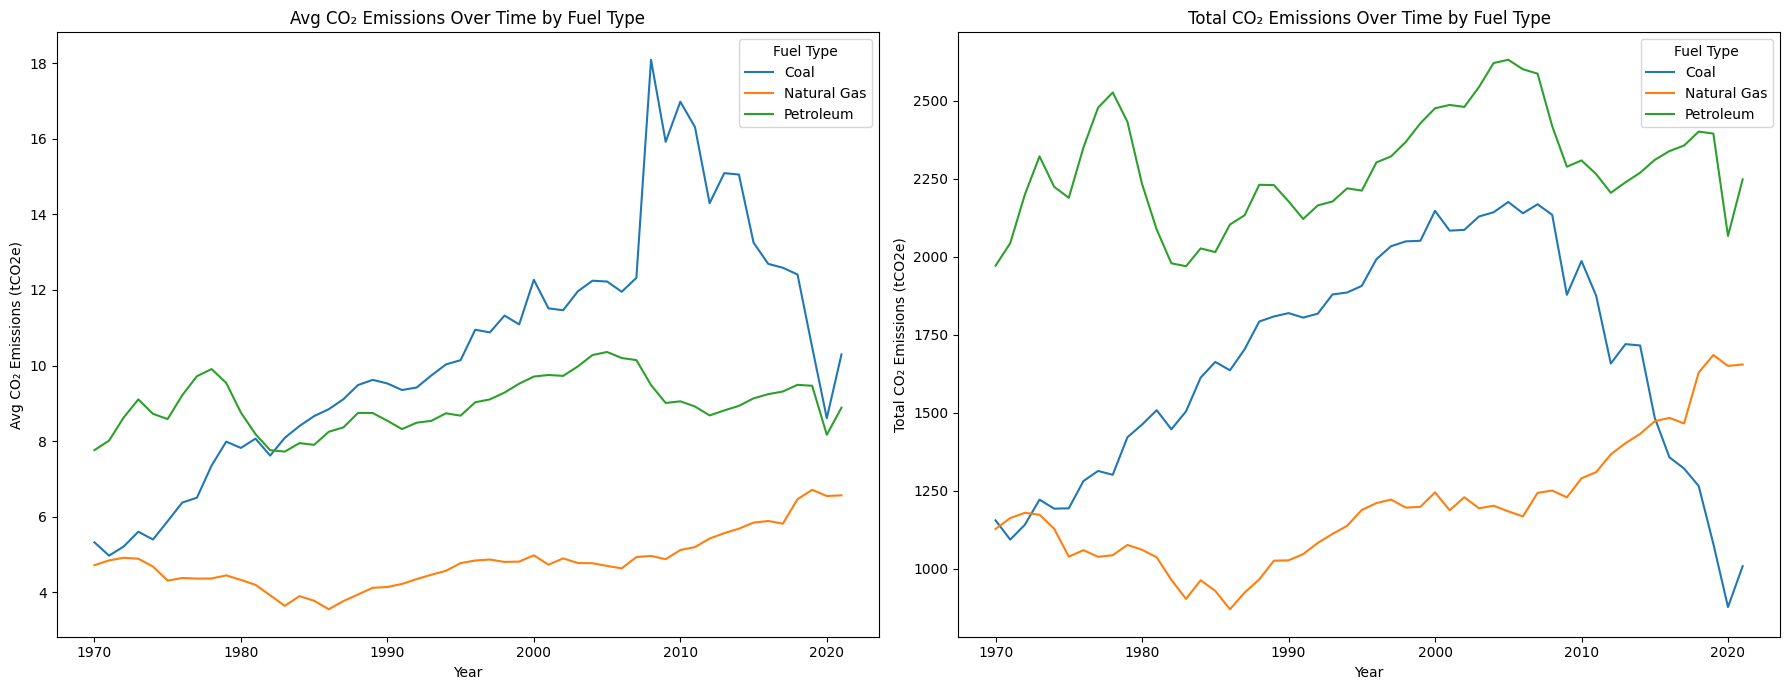

In [23]:
# --- AVERAGE EMISSIONS BY FUEL TYPE ---
avg_emissions_by_fuel = df1.groupby(['year', 'fuel-name'])['CO2 Emissions (tCO2e)'].mean().reset_index()

# --- TOTAL EMISSIONS BY FUEL TYPE ---
total_emissions_by_fuel = df1.groupby(['year', 'fuel-name'])['CO2 Emissions (tCO2e)'].sum().reset_index()

# --- PLOTTING SIDE BY SIDE ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

# Left: Average emissions
for fuel_type in avg_emissions_by_fuel['fuel-name'].unique():
    fuel_data = avg_emissions_by_fuel[avg_emissions_by_fuel['fuel-name'] == fuel_type]
    axes[0].plot(fuel_data['year'], fuel_data['CO2 Emissions (tCO2e)'], label=fuel_type)

axes[0].set_title('Avg CO₂ Emissions Over Time by Fuel Type')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Avg CO₂ Emissions (tCO2e)')
axes[0].legend(title='Fuel Type')

# Right: Total emissions
for fuel_type in total_emissions_by_fuel['fuel-name'].unique():
    fuel_data = total_emissions_by_fuel[total_emissions_by_fuel['fuel-name'] == fuel_type]
    axes[1].plot(fuel_data['year'], fuel_data['CO2 Emissions (tCO2e)'], label=fuel_type)

axes[1].set_title('Total CO₂ Emissions Over Time by Fuel Type')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total CO₂ Emissions (tCO2e)')
axes[1].legend(title='Fuel Type')

# Improve layout
plt.tight_layout()
plt.show()

Emissions by sector

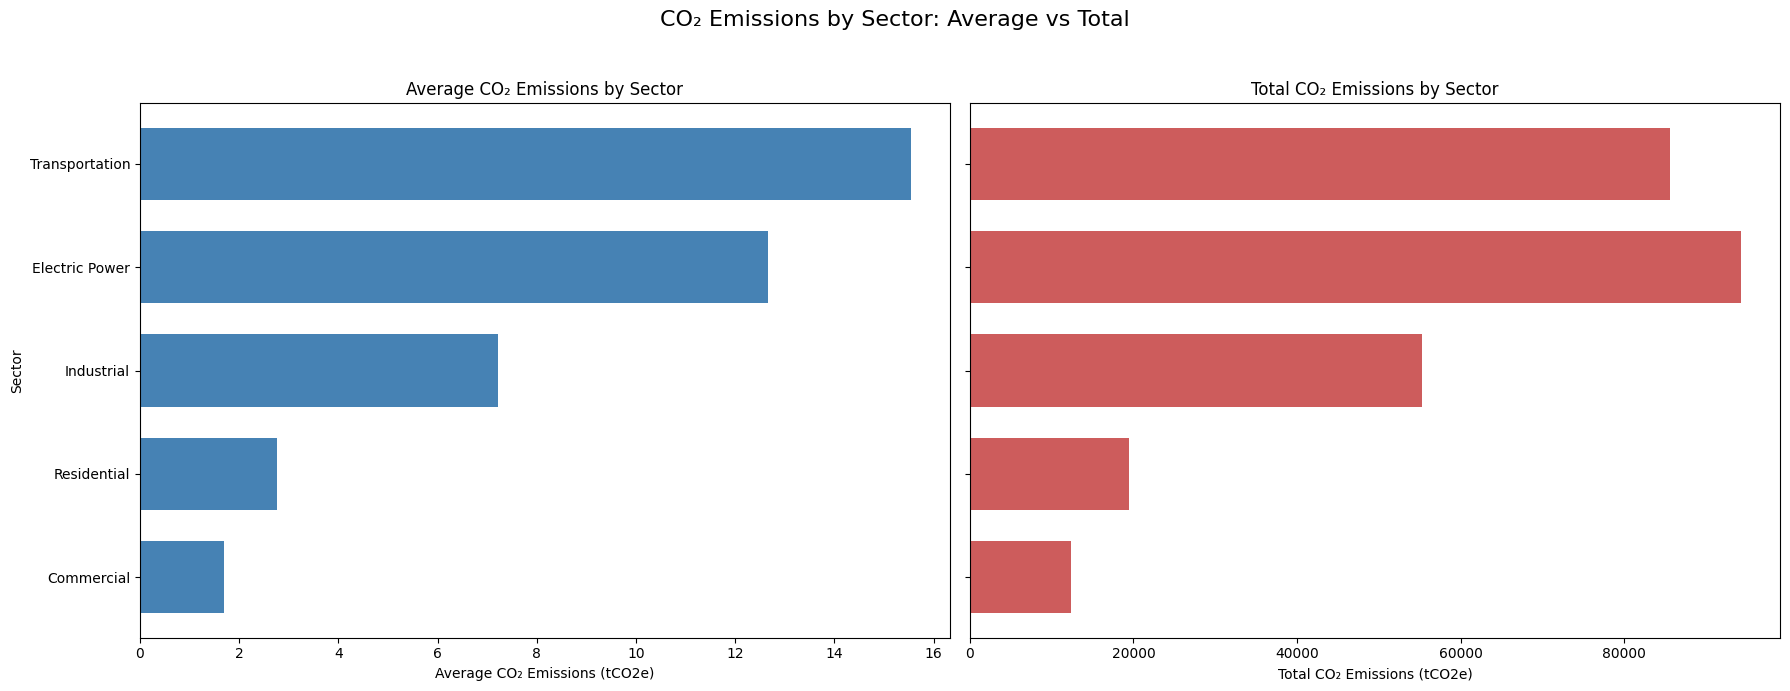

In [24]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# --- Average Emissions by Sector ---
emissions_by_sector_avg = df1.groupby("sector-name")["CO2 Emissions (tCO2e)"].mean().reset_index()
emissions_by_sector_avg = emissions_by_sector_avg.sort_values(by="CO2 Emissions (tCO2e)", ascending=True)

ax1.barh(
    y=emissions_by_sector_avg["sector-name"],
    width=emissions_by_sector_avg["CO2 Emissions (tCO2e)"],
    color="steelblue",
    height=0.7
)
ax1.set_xlabel("Average CO₂ Emissions (tCO2e)")
ax1.set_ylabel("Sector")
ax1.set_title("Average CO₂ Emissions by Sector")

# --- Total Emissions by Sector ---
emissions_by_sector_total = df1.groupby("sector-name")["CO2 Emissions (tCO2e)"].sum().reset_index()
emissions_by_sector_total = emissions_by_sector_total.sort_values(by="CO2 Emissions (tCO2e)", ascending=True)

ax2.barh(
    y=emissions_by_sector_total["sector-name"],
    width=emissions_by_sector_total["CO2 Emissions (tCO2e)"],
    color="indianred",
    height=0.7
)
ax2.set_xlabel("Total CO₂ Emissions (tCO2e)")
ax2.set_title("Total CO₂ Emissions by Sector")

# Final layout adjustments
plt.suptitle("CO₂ Emissions by Sector: Average vs Total", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Temporal trends in emissions

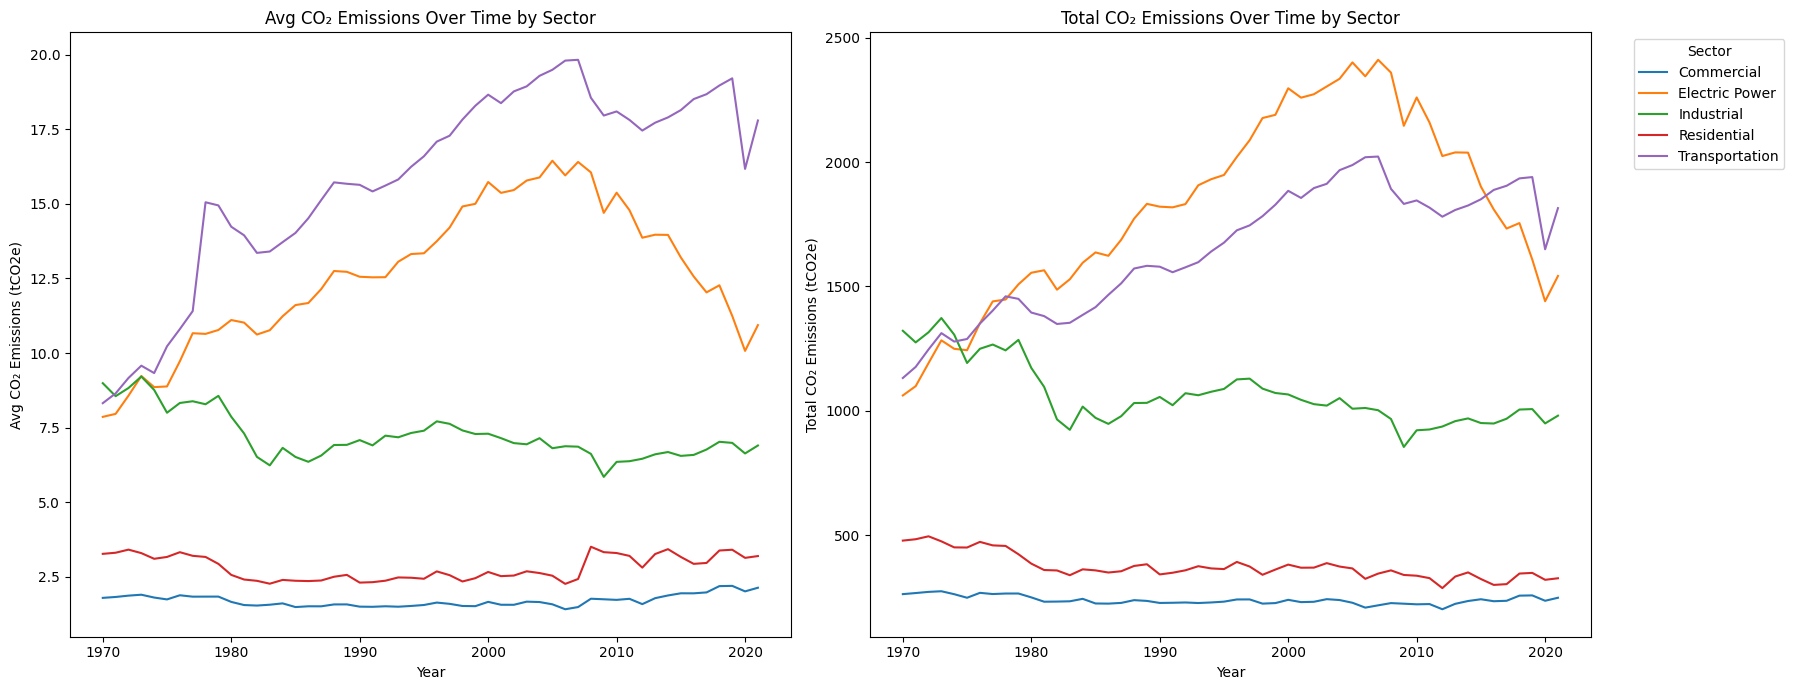

In [25]:
# --- AVERAGE EMISSIONS BY SECTOR ---
avg_emissions_by_sector = df1.groupby(['year', 'sector-name'])['CO2 Emissions (tCO2e)'].mean().reset_index()

# --- TOTAL EMISSIONS BY SECTOR ---
total_emissions_by_sector = df1.groupby(['year', 'sector-name'])['CO2 Emissions (tCO2e)'].sum().reset_index()

# --- PLOT SIDE BY SIDE ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

# Left: Average emissions
for sector in avg_emissions_by_sector['sector-name'].unique():
    sector_data = avg_emissions_by_sector[avg_emissions_by_sector['sector-name'] == sector]
    axes[0].plot(sector_data['year'], sector_data['CO2 Emissions (tCO2e)'], label=sector)

axes[0].set_title('Avg CO₂ Emissions Over Time by Sector')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Avg CO₂ Emissions (tCO2e)')


# Right: Total emissions
for sector in total_emissions_by_sector['sector-name'].unique():
    sector_data = total_emissions_by_sector[total_emissions_by_sector['sector-name'] == sector]
    axes[1].plot(sector_data['year'], sector_data['CO2 Emissions (tCO2e)'], label=sector)

axes[1].set_title('Total CO₂ Emissions Over Time by Sector')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total CO₂ Emissions (tCO2e)')
axes[1].legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Exploring Texas Data

In [26]:
# Extracting Texas Data from the dataframe

# Filter for Texas only
texas_df = df1[df1["state-name"] == "Texas"]
texas_df.head()


,year,state-name,sector-name,fuel-name,CO2 Emissions (tCO2e)
596,1970,Texas,Residential,Coal,0.001344
597,1970,Texas,Industrial,Natural Gas,133.118012
598,1970,Texas,Industrial,Petroleum,53.316855
599,1970,Texas,Industrial,Coal,2.795201
600,1970,Texas,Electric Power,Natural Gas,57.807123


In [27]:
texas_df["state-name"].value_counts()


,count
state-name,
Texas,694


### Assessing Temporal trends in CO2 emissions

Uncovering trends over the 50 years

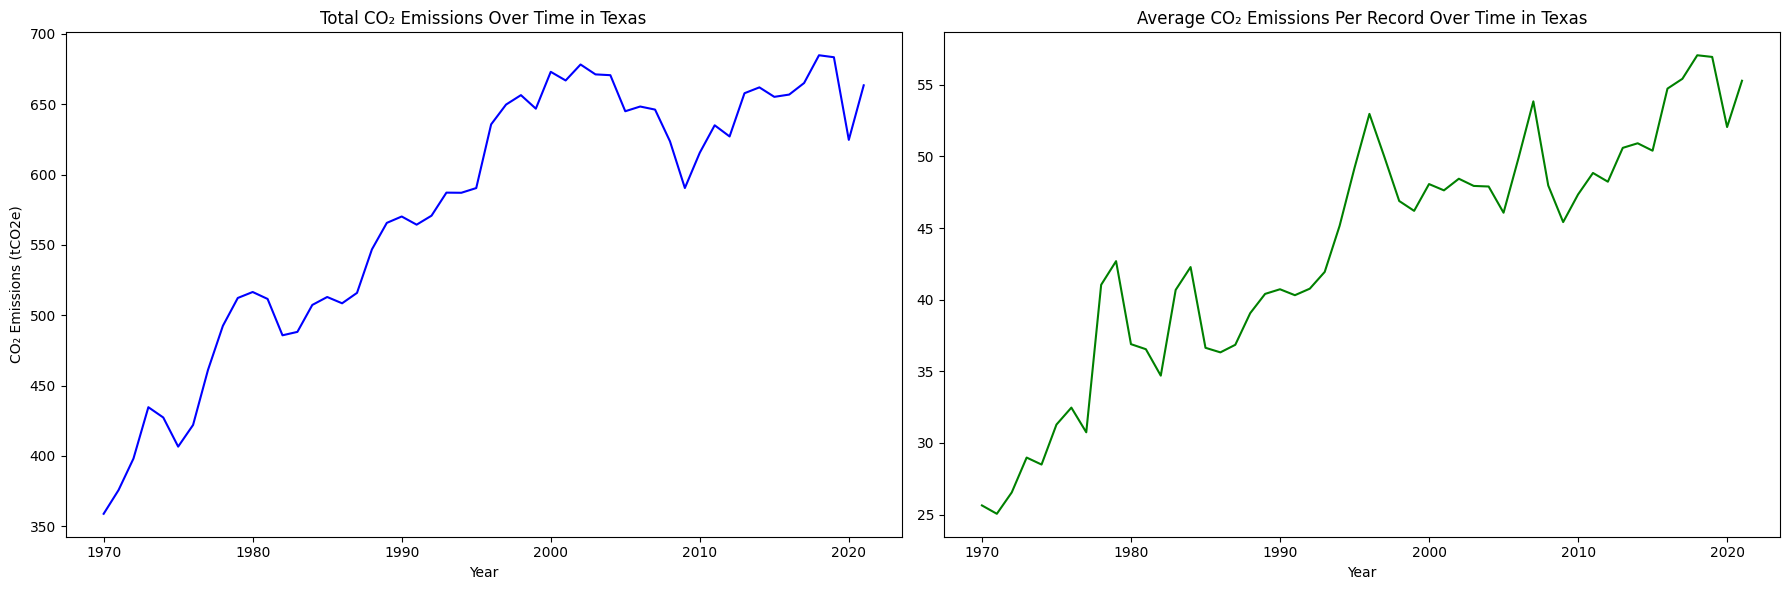

In [28]:
# Group data
emissions_by_year_sum = texas_df.groupby("year")["CO2 Emissions (tCO2e)"].sum()
emissions_by_year_avg = texas_df.groupby("year")["CO2 Emissions (tCO2e)"].mean()

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot total emissions
axes[0].plot(emissions_by_year_sum.index, emissions_by_year_sum.values, color='blue')
axes[0].set_title("Total CO₂ Emissions Over Time in Texas")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("CO₂ Emissions (tCO2e)")

# Plot average emissions
axes[1].plot(emissions_by_year_avg.index, emissions_by_year_avg.values, color='green')
axes[1].set_title("Average CO₂ Emissions Per Record Over Time in Texas")
axes[1].set_xlabel("Year")


# Improve layout
plt.tight_layout()
plt.show()

Uncovering trends in emissions from 2000 onwards

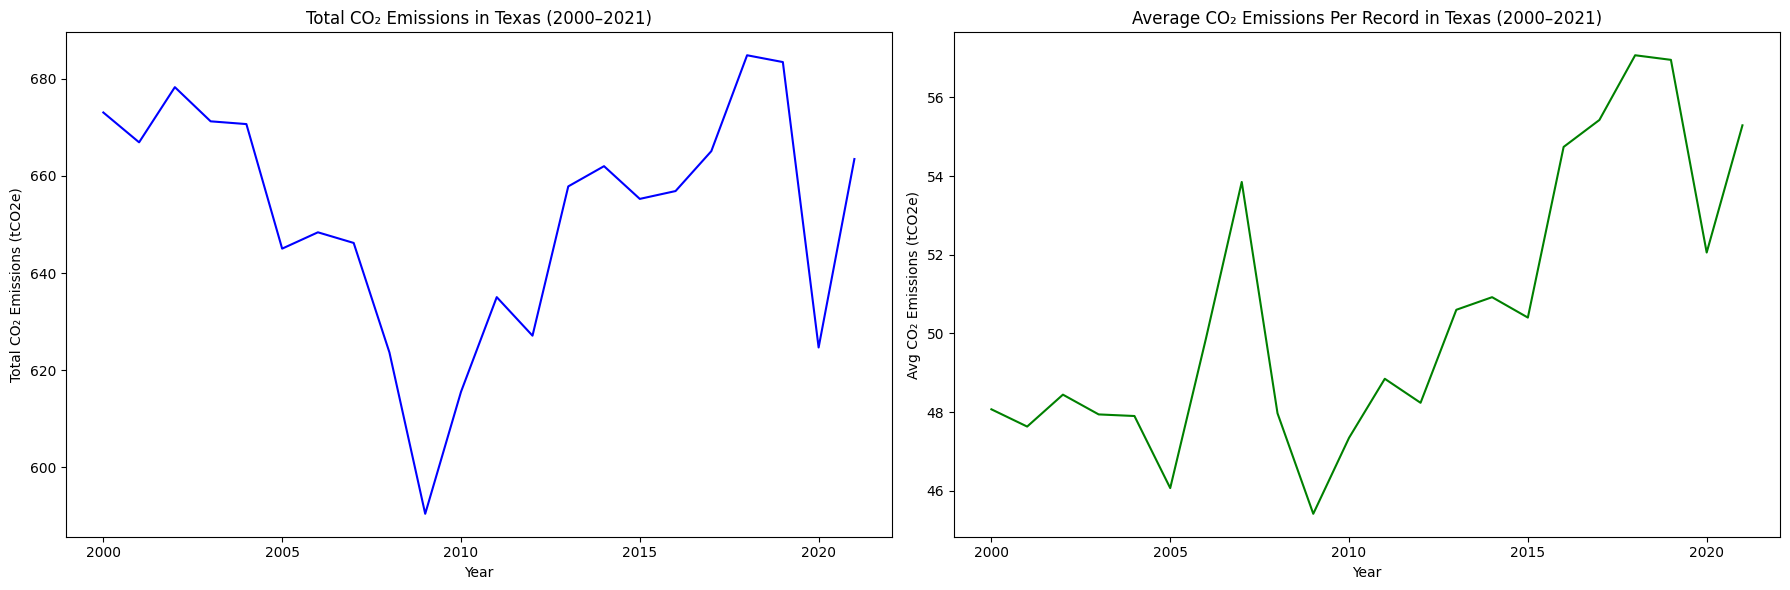

In [29]:
# Filter data for Texas from year 2000 onwards
texas_df_2000 = texas_df[texas_df["year"] >= 2000]

# Group data
emissions_by_year_sum = texas_df_2000.groupby("year")["CO2 Emissions (tCO2e)"].sum()
emissions_by_year_avg = texas_df_2000.groupby("year")["CO2 Emissions (tCO2e)"].mean()

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot total emissions
axes[0].plot(emissions_by_year_sum.index, emissions_by_year_sum.values, color='blue')
axes[0].set_title("Total CO₂ Emissions in Texas (2000–2021)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Total CO₂ Emissions (tCO2e)")

# Plot average emissions
axes[1].plot(emissions_by_year_avg.index, emissions_by_year_avg.values, color='green')
axes[1].set_title("Average CO₂ Emissions Per Record in Texas (2000–2021)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Avg CO₂ Emissions (tCO2e)")

# Improve layout
plt.tight_layout()
plt.show()


In [30]:
# Check fuel-specific average emissions in Texas for 2006
texas_2006 = texas_df[texas_df["year"] == 2006]
texas_2006.groupby("fuel-name")["CO2 Emissions (tCO2e)"].mean().sort_values(ascending=False)


,CO2 Emissions (tCO2e)
fuel-name,
Petroleum,61.935076
Coal,51.213465
Natural Gas,37.013277


In [31]:
# Group by fuel type and calculate average emissions
avg_fuel_emissions_tx = (
    texas_df.groupby("fuel-name")["CO2 Emissions (tCO2e)"]
    .mean()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=False)
)

# Round for better readability
avg_fuel_emissions_tx["CO2 Emissions (tCO2e)"] = avg_fuel_emissions_tx["CO2 Emissions (tCO2e)"].round(2)

# Display
print(avg_fuel_emissions_tx)


     fuel-name  CO2 Emissions (tCO2e)
2    Petroleum                  51.28
1  Natural Gas                  41.96
0         Coal                  32.24


In [32]:
# Group by fuel type and calculate total emissions
total_fuel_emissions_tx = (
    texas_df.groupby("fuel-name")["CO2 Emissions (tCO2e)"]
    .sum()  # Changed from mean() to sum()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=False)
)

# Round for better readability (optional, but good practice for consistency)
total_fuel_emissions_tx["CO2 Emissions (tCO2e)"] = total_fuel_emissions_tx["CO2 Emissions (tCO2e)"].round(2)

# Display
print("Total CO₂ Emissions in Texas by Fuel Type:")
print(total_fuel_emissions_tx)

Total CO₂ Emissions in Texas by Fuel Type:
     fuel-name  CO2 Emissions (tCO2e)
2    Petroleum               13333.45
1  Natural Gas               10909.84
0         Coal                5609.39


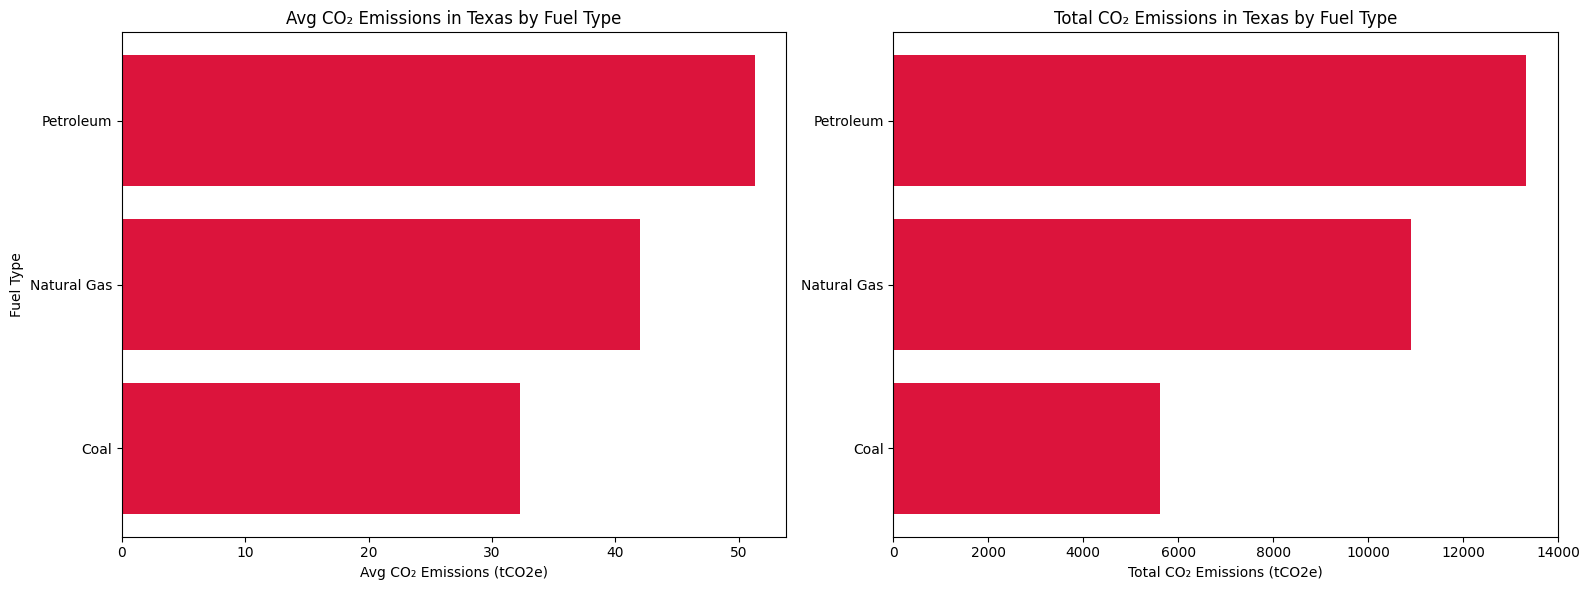

In [33]:
# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# --- Average Emissions by Fuel Type ---
avg_fuel_emissions_tx = (
    texas_df.groupby("fuel-name")["CO2 Emissions (tCO2e)"]
    .mean()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=False)
)

# --- Average CO₂ Emissions in Texas by Fuel Type ---
axes[0].barh(avg_fuel_emissions_tx["fuel-name"], avg_fuel_emissions_tx["CO2 Emissions (tCO2e)"], color="crimson")
axes[0].set_title("Avg CO₂ Emissions in Texas by Fuel Type")
axes[0].set_xlabel("Avg CO₂ Emissions (tCO2e)")
axes[0].set_ylabel("Fuel Type")
axes[0].invert_yaxis()  # Highest bar at the top


# --- Total Emissions by Sector ---
total_fuel_emissions_tx = (
    texas_df.groupby("fuel-name")["CO2 Emissions (tCO2e)"]
    .sum()  # Changed from mean() to sum()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=False)
)

# --- Total CO₂ Emissions in Texas by Fuel Type ---
axes[1].barh(total_fuel_emissions_tx["fuel-name"], total_fuel_emissions_tx["CO2 Emissions (tCO2e)"], color="crimson")
axes[1].set_title("Total CO₂ Emissions in Texas by Fuel Type")
axes[1].set_xlabel("Total CO₂ Emissions (tCO2e)")
axes[1].invert_yaxis()

# Layout fix
plt.tight_layout()
plt.show()


Analysing emissions by sector

In [34]:
# Group by sector and calculate average CO₂ emissions in Texas
avg_sector_emissions_tx = (
    texas_df.groupby("sector-name")["CO2 Emissions (tCO2e)"]
    .mean()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=False)
)

# Round for clarity
avg_sector_emissions_tx["CO2 Emissions (tCO2e)"] = avg_sector_emissions_tx["CO2 Emissions (tCO2e)"].round(2)

# Display results
print(avg_sector_emissions_tx)


      sector-name  CO2 Emissions (tCO2e)
4  Transportation                  75.70
2      Industrial                  68.95
1  Electric Power                  59.77
3     Residential                   5.37
0      Commercial                   4.65


In [35]:
# Group by sector and calculate total CO₂ emissions in Texas
total_sector_emissions_tx = (
    texas_df.groupby("sector-name")["CO2 Emissions (tCO2e)"]
    .sum()  # Changed from mean() to sum()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=False)
)

# Round for clarity (optional, but good practice)
total_sector_emissions_tx["CO2 Emissions (tCO2e)"] = total_sector_emissions_tx["CO2 Emissions (tCO2e)"].round(2)

# Display results
print("Total CO₂ Emissions in Texas by Sector:")
print(total_sector_emissions_tx)

Total CO₂ Emissions in Texas by Sector:
      sector-name  CO2 Emissions (tCO2e)
2      Industrial               10756.20
1  Electric Power                9264.95
4  Transportation                8478.02
3     Residential                 698.23
0      Commercial                 655.28


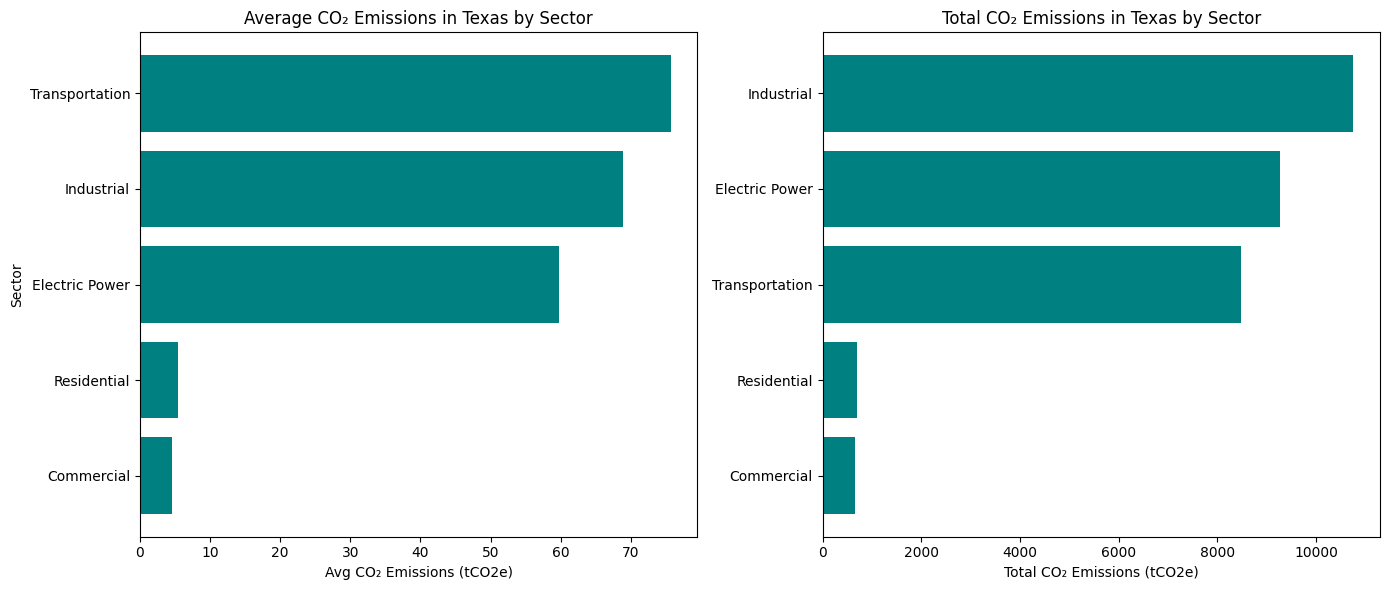

In [36]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Group by sector and calculate average CO₂ emissions in Texas
avg_sector_emissions_tx = (
    texas_df.groupby("sector-name")["CO2 Emissions (tCO2e)"]
    .mean()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=True)
)

# First horizontal bar chart - Average CO₂ Emissions by Sector
ax[0].barh(avg_sector_emissions_tx["sector-name"], avg_sector_emissions_tx["CO2 Emissions (tCO2e)"], color="teal")
ax[0].set_title("Average CO₂ Emissions in Texas by Sector")
ax[0].set_xlabel("Avg CO₂ Emissions (tCO2e)")
ax[0].set_ylabel("Sector")
ax[0].tick_params(axis="y", rotation=0)



# Group by sector and calculate total CO₂ emissions in Texas
total_sector_emissions_tx = (
    texas_df.groupby("sector-name")["CO2 Emissions (tCO2e)"]
    .sum()  # Changed from mean() to sum()
    .reset_index()
    .sort_values(by="CO2 Emissions (tCO2e)", ascending=True)
)

# Second horizontal bar chart - Total CO₂ Emissions by Sector
ax[1].barh(total_sector_emissions_tx["sector-name"], total_sector_emissions_tx["CO2 Emissions (tCO2e)"], color="teal")
ax[1].set_title("Total CO₂ Emissions in Texas by Sector")
ax[1].set_xlabel("Total CO₂ Emissions (tCO2e)")
ax[1].tick_params(axis="y", rotation=0)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()


Analysing emissions post 2000 for sector

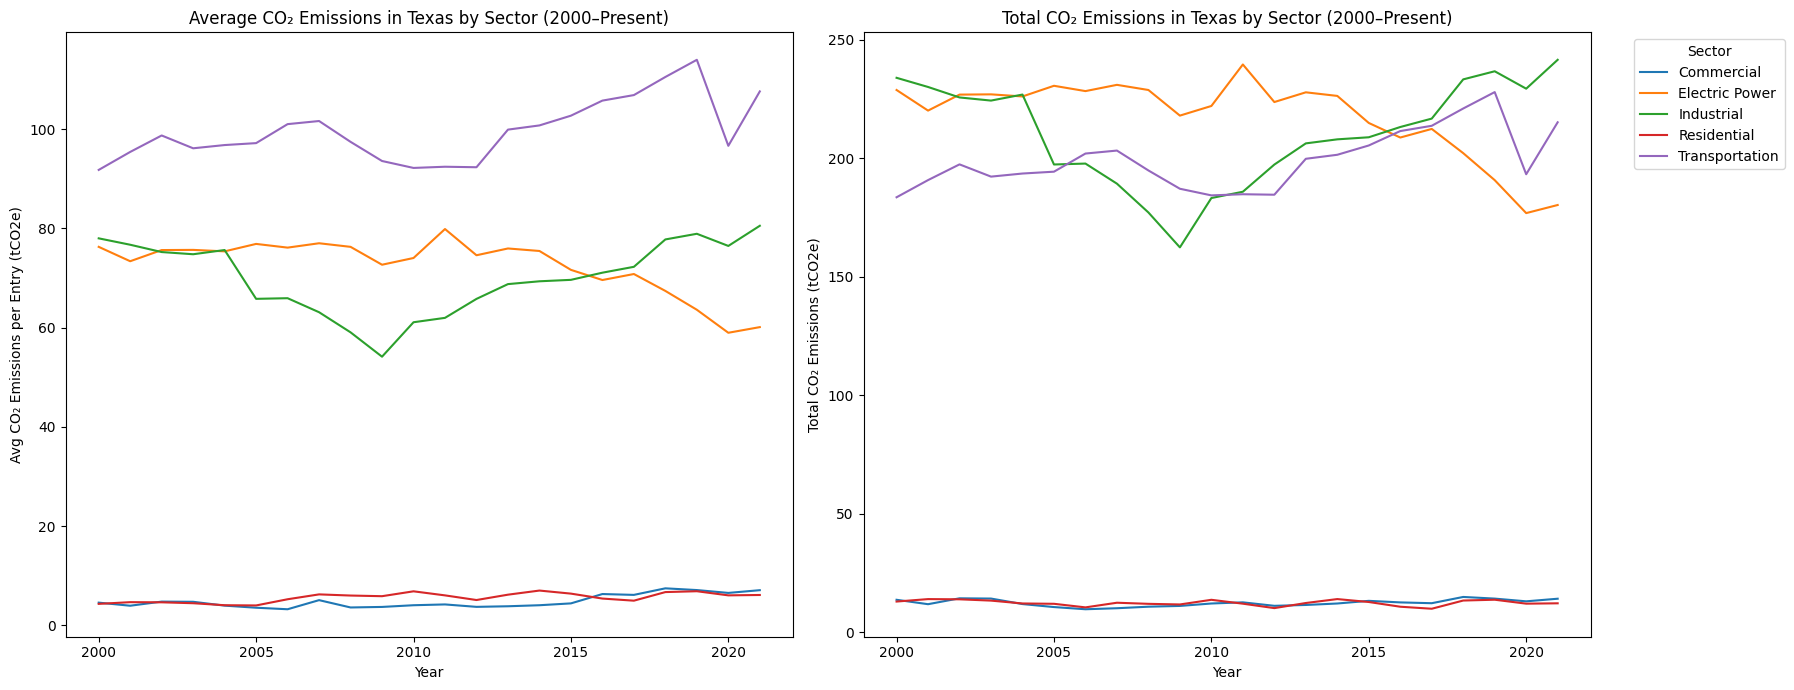

In [37]:
# Filter for Texas and post-2000 data
texas_post2000 = df1[(df1["state-name"] == "Texas") & (df1["year"] >= 2000)]

# --- Group by year and sector, and calculate average emissions ---
avg_sector_emissions_tx = (
    texas_post2000.groupby(["year", "sector-name"])["CO2 Emissions (tCO2e)"]
    .mean()
    .reset_index()
)

# --- Group by year and sector, and calculate total emissions ---
total_sector_emissions_tx = (
    texas_post2000.groupby(["year", "sector-name"])["CO2 Emissions (tCO2e)"]
    .sum()
    .reset_index()
)

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# --- Plot average emissions ---
for sector in avg_sector_emissions_tx["sector-name"].unique():
    data = avg_sector_emissions_tx[avg_sector_emissions_tx["sector-name"] == sector]
    axes[0].plot(data["year"], data["CO2 Emissions (tCO2e)"], label=sector)

axes[0].set_title("Average CO₂ Emissions in Texas by Sector (2000–Present)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Avg CO₂ Emissions per Entry (tCO2e)")

# --- Plot total emissions ---
for sector in total_sector_emissions_tx["sector-name"].unique():
    data = total_sector_emissions_tx[total_sector_emissions_tx["sector-name"] == sector]
    axes[1].plot(data["year"], data["CO2 Emissions (tCO2e)"], label=sector)

axes[1].set_title("Total CO₂ Emissions in Texas by Sector (2000–Present)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total CO₂ Emissions (tCO2e)")
axes[1].legend(title="Sector", bbox_to_anchor=(1.05, 1), loc="upper left")

# Layout
plt.tight_layout()
plt.show()


Analysing emissions post 2000 for fuel type

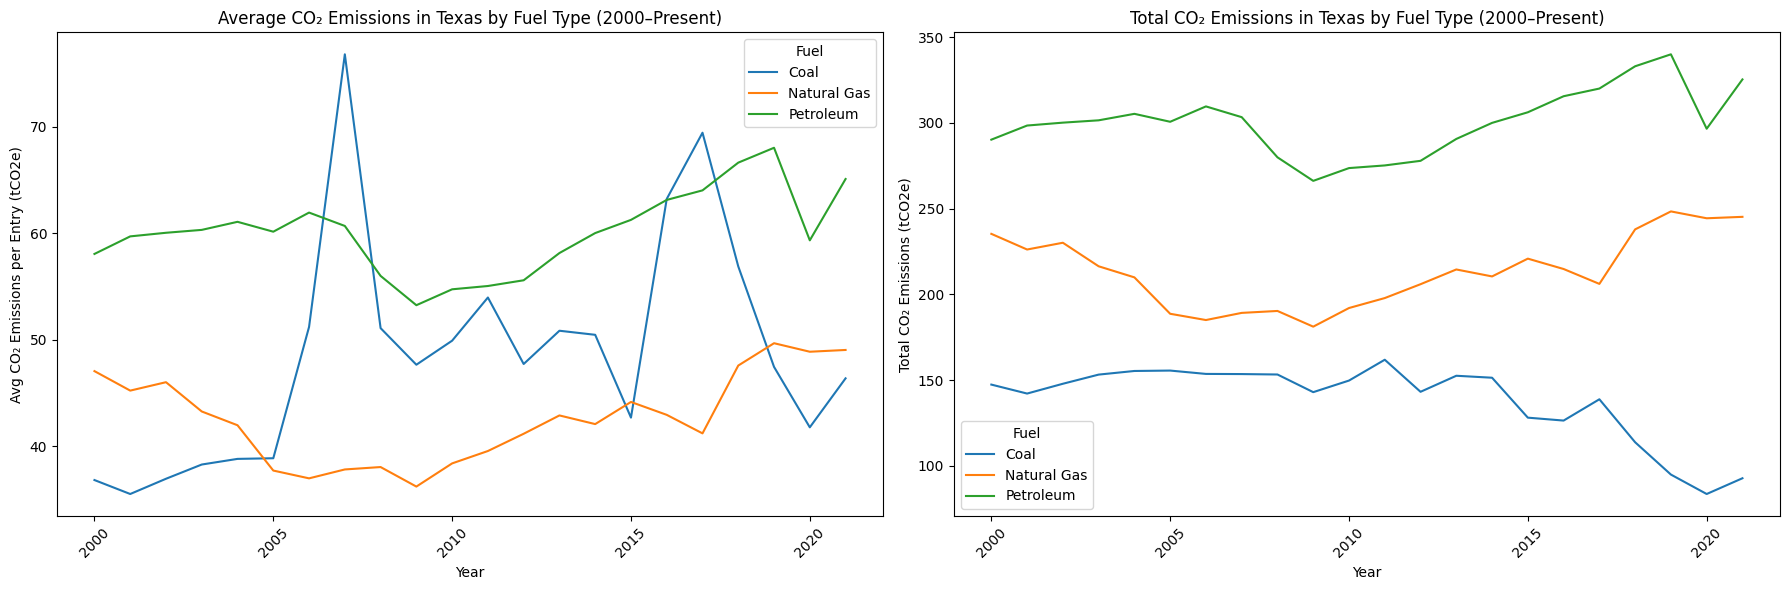

In [38]:
# Average emissions by fuel over time (Texas only)
avg_fuel_emissions_tx = (
    texas_post2000.groupby(["year", "fuel-name"])["CO2 Emissions (tCO2e)"]
    .mean()
    .reset_index()
)

# Total emissions by fuel over time (Texas only)
total_fuel_emissions_tx = (
    texas_post2000.groupby(["year", "fuel-name"])["CO2 Emissions (tCO2e)"]
    .sum()  # Changed from mean() to sum()
    .reset_index()
)

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot for average emissions
for fuel in avg_fuel_emissions_tx["fuel-name"].unique():
    data = avg_fuel_emissions_tx[avg_fuel_emissions_tx["fuel-name"] == fuel]
    axes[0].plot(data["year"], data["CO2 Emissions (tCO2e)"], label=fuel)

axes[0].set_title("Average CO₂ Emissions in Texas by Fuel Type (2000–Present)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Avg CO₂ Emissions per Entry (tCO2e)")
axes[0].legend(title="Fuel")
axes[0].tick_params(axis='x', rotation=45)

# Plot for total emissions
for fuel in total_fuel_emissions_tx["fuel-name"].unique():
    data = total_fuel_emissions_tx[total_fuel_emissions_tx["fuel-name"] == fuel]
    axes[1].plot(data["year"], data["CO2 Emissions (tCO2e)"], label=fuel)

axes[1].set_title("Total CO₂ Emissions in Texas by Fuel Type (2000–Present)")  # Updated title
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total CO₂ Emissions (tCO2e)")  # Updated label
axes[1].legend(title="Fuel")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()
